# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")


## test the LightGlue class  dd

fatal: destination path 'LightGlue' already exists and is not an empty directory.
/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/stereo_matching_lightglue/LightGlue


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [3]:
%pip install ultralytics
from IPython import display
display.clear_output()

from ultralytics import YOLO

In [26]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
from sync_tools import calculate_offset_fft
from ultralytics import YOLO
from track_and_match_tools import get_yolo_tracks_left_right, get_id_matches_lightglue

model = YOLO("/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/best_close_chromis.pt")
video1_path = "/Volumes/HD_Feeding/29_11_2023_dep1/3/GX040028.MP4"
video2_path = "/Volumes/HD_Feeding/29_11_2023_dep1/4/GX040247.MP4"

#get freames per second of video1
import cv2
cap = cv2.VideoCapture(video1_path)
fps = cap.get(cv2.CAP_PROP_FPS)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#offset = int(fps*calculate_offset_fft(video1_path, video2_path))
offset = -118
start_frame = 200

n_frames = 10
left_tracks, right_tracks = get_yolo_tracks_left_right(start_frame, n_frames, offset, model, video1_path, video2_path)
all_matched_ids = get_id_matches_lightglue(start_frame, offset, n_frames, video1_path, video2_path,left_tracks, right_tracks)

print("Left Tracks:", left_tracks)
print("Right Tracks:", right_tracks)
print("All Matched IDs:", all_matched_ids)


0: 2176x3840 4 chromiss, 7505.9ms
Speed: 64.3ms preprocess, 7505.9ms inference, 2.8ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 4 chromiss, 6681.0ms
Speed: 38.0ms preprocess, 6681.0ms inference, 5.0ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 4 chromiss, 6709.1ms
Speed: 38.9ms preprocess, 6709.1ms inference, 2.1ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 4 chromiss, 6618.1ms
Speed: 38.1ms preprocess, 6618.1ms inference, 3.5ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 3 chromiss, 6585.1ms
Speed: 46.5ms preprocess, 6585.1ms inference, 6.1ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 4 chromiss, 6672.5ms
Speed: 39.1ms preprocess, 6672.5ms inference, 4.7ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 3 chromiss, 6529.3ms
Speed: 39.7ms preprocess, 6529.3ms inference, 5.8ms postprocess per image at shape (1, 3, 2176, 3840)

0: 2176x3840 4 chromiss, 6558.3ms
Speed:

Left Tracks: [[          1         200      1950.1      1195.1        2055      1249.3]
 [          2         200      2485.2      742.77      2556.3       787.2]
 [          3         200      1963.3      781.13      2055.7      816.23]
 [          4         200      1944.2      956.64      1972.6      1017.9]
 [          1         201      1948.1      1192.9      2050.6      1246.4]
 [          2         201      2489.4      745.88      2560.9      787.92]
 [          3         201      1961.9      781.09      2054.1      816.56]
 [          4         201      1943.9      950.05      1971.3      1012.2]
 [          1         202      1945.2        1191      2045.8        1244]
 [          2         202      2494.7      747.86      2565.5      788.83]
 [          3         202      1958.4      779.63      2051.1      816.66]
 [          4         202      1943.3       943.9        1969      1005.3]
 [          1         203      1940.2      1189.1      2042.8      1240.6]
 [          

In [ ]:
import cv2
import pandas as pd
import numpy as np
from collections import defaultdict

def prepare_annotations(annotations_path):
    """
    Prepares the annotations for fast access by indexing by frame number.
    """
    annotations = pd.read_csv(annotations_path, sep=' ')
    annotations.columns = ['track_id', 'frame number', 'x1', 'y1', 'x2', 'y2']
    annotations_by_frame = defaultdict(list)
    for index, row in annotations.iterrows():
        frame_number = row['frame number']
        annotations_by_frame[frame_number].append(row)
    return annotations_by_frame

def draw_bounding_boxes(frame, annotations):
    """
    Draw bounding boxes and track IDs on a frame and return coordinates of bounding boxes.
    """
    bb_coords = {}
    for row in annotations:
        x1, y1, x2, y2, track_id = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2']), int(row['track_id'])
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 200, 255), 2)
        cv2.putText(frame, str(track_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 200, 255), 2)
        bb_coords[track_id] = ((x1 + x2) // 2, (y1 + y2) // 2)  # Store center coordinates of the bounding box
    return frame, bb_coords

def draw_lines(frame, matches, bb_coords_left, bb_coords_right, frame_number):
    """
    Draw lines connecting matching bounding boxes between left and right frames.
    """
    frame_matches = matches[matches['frame_num'] == frame_number]
    for _, row in frame_matches.iterrows():
        id_left = row['id_left']
        id_right = row['id_right']
        if id_left in bb_coords_left and id_right in bb_coords_right:
            pt1 = bb_coords_left[id_left]
            pt2 = (bb_coords_right[id_right][0] + frame.shape[1] // 2, bb_coords_right[id_right][1])  # Adjust for horizontal stacking
            cv2.line(frame, pt1, pt2, (0, 0, 255), 2)
    return frame

def process_and_stack_videos(video1_path, video2_path, annotations1_path, annotations2_path, matches_path, output_video_path, start_frame, n_frames, offset=0):
    # Prepare annotations for fast access
    annotations1_by_frame = prepare_annotations(annotations1_path)
    annotations2_by_frame = prepare_annotations(annotations2_path)
    matches = pd.read_csv(matches_path)
    matches.columns = ['frame_num', 'id_left', 'id_right']

    # Initialize video capture
    cap1 = cv2.VideoCapture(video1_path)
    cap2 = cv2.VideoCapture(video2_path)

    # Set starting frame position
    cap1.set(cv2.CAP_PROP_POS_FRAMES, start_frame + offset)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Get video properties
    width1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
    height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap1.get(cv2.CAP_PROP_FPS)

    # Check that both videos have the same height
    if height1 != height2:
        raise ValueError("The heights of the two videos do not match.")

    # Initialize video writer
    output_width = width1 + width2
    output_height = height1
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, output_height))

    # Process each frame
    for frame_idx in range(n_frames):
        print(f'Processing frame {frame_idx}...')
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()

        if not ret1 or not ret2:
            break  #

        frame_number =  frame_idx + start_frame

        # Draw bounding boxes and track IDs
        frame1_annotations = annotations1_by_frame.get(frame_number, [])
        frame2_annotations = annotations2_by_frame.get(frame_number, [])
        frame1, bb_coords_left = draw_bounding_boxes(frame1, frame1_annotations)
        frame2, bb_coords_right = draw_bounding_boxes(frame2, frame2_annotations)

        # Stack frames horizontally
        combined_frame = np.hstack((frame1, frame2))

        # Draw lines connecting matched bounding boxes
        combined_frame = draw_lines(combined_frame, matches, bb_coords_left, bb_coords_right, frame_number)

        # Write the frame to the output video
        out.write(combined_frame)

        # Debug output to verify bounding boxes and lines
        # cv2.imshow('Combined Frame', combined_frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Release resources
    cap1.release()
    cap2.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage
video1_path = "/Volumes/HD_Feeding/29_11_2023_dep1/3/GX040028.MP4"
video2_path = "/Volumes/HD_Feeding/29_11_2023_dep1/4/GX040247.MP4"
annotations1_path = '/Users/benmartin/Downloads/left_tracks.csv'
annotations2_path = '/Users/benmartin/Downloads/right_tracks.csv'
matches_path = '/Users/benmartin/Downloads/all_matched_ids.csv'
output_video_path = 'output_video2.mp4'
offset = -118
start_frame = 200
n_frames = 2000  # Change this to the number of frames you want to process

process_and_stack_videos(video1_path, video2_path, annotations1_path, annotations2_path, matches_path, output_video_path, start_frame, n_frames, offset)


In [18]:
# read in csv file

array([          9,           2,           1,           3,          14,          17,          18,          23,          25,          29,          32,          33,          34,          36,          50,          54,          63,          65])

In [12]:
n_frames = 2
left_tracks, right_tracks = get_yolo_tracks_left_right(start_frame, n_frames, offset, model, video1_path, video2_path)
all_matched_ids = get_id_matches_lightglue(start_frame, offset, n_frames, video1_path, video2_path,left_tracks, right_tracks)

print("Left Tracks:", left_tracks)
print("Right Tracks:", right_tracks)



0: 1088x1920 6 chromiss, 1830.9ms
Speed: 19.0ms preprocess, 1830.9ms inference, 3.6ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1754.5ms
Speed: 13.2ms preprocess, 1754.5ms inference, 2.8ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 chromis, 1730.3ms
Speed: 14.1ms preprocess, 1730.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1763.3ms
Speed: 11.9ms preprocess, 1763.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1088, 1920)


NameError: name 'load_image' is not defined

Number of matches: 908


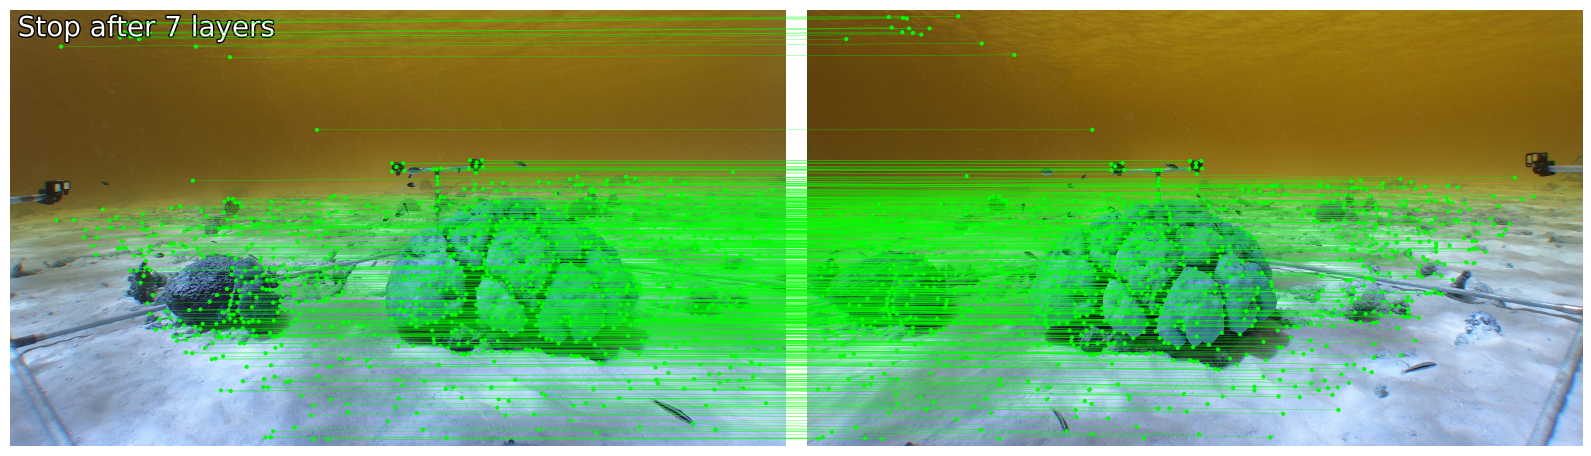

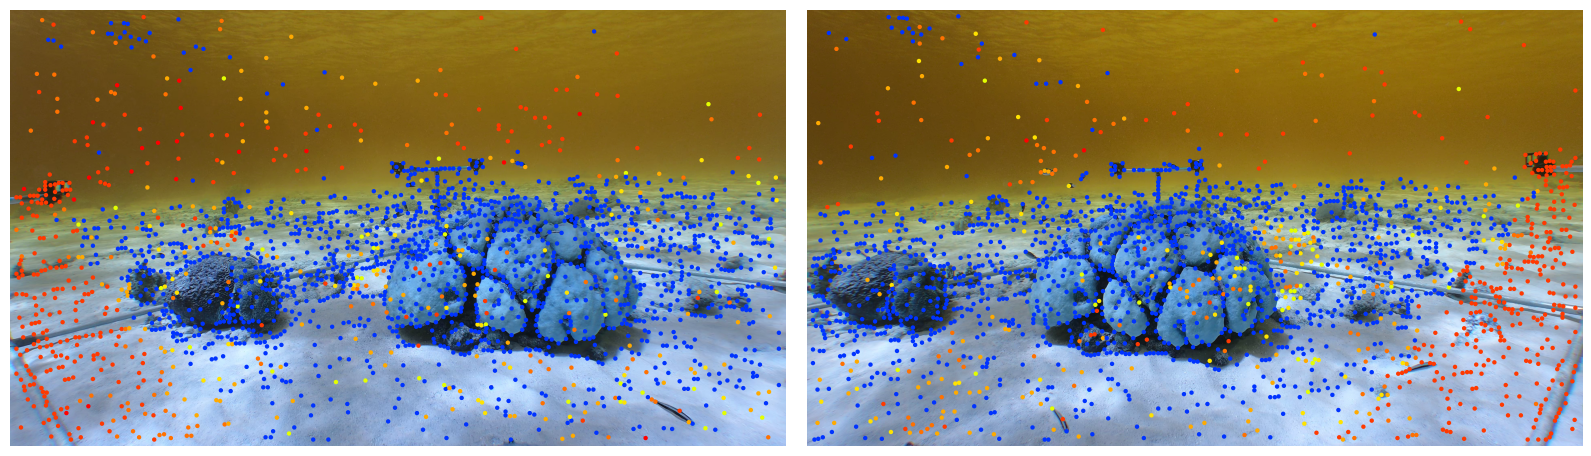

In [25]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

cap1 = cv2.VideoCapture(video1_path)
cap1.set(cv2.CAP_PROP_POS_FRAMES, offset + start_frame)
ret, frame1 = cap1.read()
cap2 = cv2.VideoCapture(video2_path)
cap2.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
ret, frame2 = cap2.read()

#save frames
cv2.imwrite('frame1.png', frame1)
cv2.imwrite('frame2.png', frame2)

# Save the frames temporarily
cv2.imwrite("frame1.png", cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR))
cv2.imwrite("frame2.png", cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

image0 = load_image("frame1.png")
image1 = load_image("frame2.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]


axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

#print number of matches
print(f"Number of matches: {matches01['matches'].shape[0]}")


In [27]:
# get max value of first column of m_kpts0
max_value = m_kpts0.max(axis=0)
max_value

torch.return_types.max(
values=tensor([3807.6248, 2127.6250]),
indices=tensor([626, 520]))

In [20]:
import numpy as np

def find_matches(left_bbs, right_bbs, m_kpts0, m_kpts1):
    matches_in_box_left = []
    matches_in_box_left_index = []

    for bb in left_bbs:
        id, frame, x1, y1, x2, y2 = bb
        for j, match in enumerate(m_kpts0):
            if x1 < match[0] < x2 and y1 < match[1] < y2:
                matches_in_box_left.append(id)
                matches_in_box_left_index.append(j)

    matches_in_box_right = []
    matches_in_box_right_index = []

    for bb in right_bbs:
        id, frame, x1, y1, x2, y2 = bb
        for j, match in enumerate(m_kpts1):
            if x1 < match[0] < x2 and y1 < match[1] < y2:
                matches_in_box_right.append(id)
                matches_in_box_right_index.append(j)

    # Find common elements
    common_elements = set(matches_in_box_left_index).intersection(set(matches_in_box_right_index))

    # Create a table to store the indices
    table = []

    # Find the indices of common elements in both lists
    for element in common_elements:
        indices_list1 = [i for i, x in enumerate(matches_in_box_left_index) if x == element]
        indices_list2 = [i for i, x in enumerate(matches_in_box_right_index) if x == element]
        for index1 in indices_list1:
            for index2 in indices_list2:
                table.append({'Value': element, 'Index in list1': index1, 'Index in list2': index2})

    # Extract indices into NumPy arrays
    left_ids = np.array([row['Index in list1'] for row in table], dtype=int)
    right_ids = np.array([row['Index in list2'] for row in table], dtype=int)

    # Convert lists to NumPy arrays
    matches_in_box_right = np.array(matches_in_box_right)
    matches_in_box_left = np.array(matches_in_box_left)

    # Use a set to store unique pairs
    unique_matches = set((matches_in_box_left[left_id], matches_in_box_right[right_id])
                         for left_id, right_id in zip(left_ids, right_ids))

    # Convert the set back to a list
    matched_data = list(unique_matches)

    return matched_data

# Example usage:


matched_data = find_matches(left_bbs, right_bbs, m_kpts0, m_kpts1)
print(matched_data)


[(6.0, 12.0), (4.0, 10.0), (1.0, 7.0), (3.0, 9.0)]


## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

In [41]:
import cv2
import numpy as np

def get_yolo_tracks_left_right(start_frame, n_frames, offset, model, video1_path, video2_path):
    # Initialize video capture
    cap1 = cv2.VideoCapture(video1_path)
    cap1.set(cv2.CAP_PROP_POS_FRAMES, start_frame + offset)
    
    cap2 = cv2.VideoCapture(video2_path)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    left_tracks = []
    right_tracks = []

    # Process left video
    for i in range(n_frames):
        ret, frame = cap1.read()
        if not ret:
            break
        results_left = model.track(source=frame, persist=True)
        
        if results_left[0].boxes is not None:
            for box in results_left[0].boxes.data:
                x1, y1, x2, y2, id, conf = box[0:6].detach().cpu().numpy()
                frame_number = i
                left_tracks.append([id, frame_number, x1, y1, x2, y2])

    # Process right video
    for i in range(n_frames):
        ret, frame = cap2.read()
        if not ret:
            break
        results_right = model.track(source=frame, persist=True)
        
        if results_right[0].boxes is not None:
            for box in results_right[0].boxes.data:
                x1, y1, x2, y2, id, conf = box[0:6].detach().cpu().numpy()
                frame_number = i
                right_tracks.append([id, frame_number, x1, y1, x2, y2])

    # Convert lists to numpy arrays
    left_tracks = np.array(left_tracks)
    right_tracks = np.array(right_tracks)

    return left_tracks, right_tracks



In [49]:
import cv2
import numpy as np

def get_id_matches_lightglue(start_frame, offset, n_frames, video1_path, video2_path,left_tracks, right_tracks):
    # Initialize video capture
    cap1 = cv2.VideoCapture(video1_path)
    cap1.set(cv2.CAP_PROP_POS_FRAMES, offset + start_frame)
    
    cap2 = cv2.VideoCapture(video2_path)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Assume these are provided by your environment
    # rt = np.array(right_tracks)  # Right bounding boxes with tracking data
    # lt = np.array(left_tracks)   # Left bounding boxes with tracking data

    # You would populate rt and lt with your tracking data before this function call
    rt = np.array(right_tracks)  # Replace with actual right tracking data
    lt = np.array(left_tracks)   # Replace with actual left tracking data

    all_matched_ids = []

    for i in range(n_frames):
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2:
            break

        # Save the frames temporarily
        cv2.imwrite("frame1.png", cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR))
        cv2.imwrite("frame2.png", cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR))
        image0 = load_image("frame1.png")
        image1 = load_image("frame2.png")

        feats0 = extractor.extract(image0.to(device))
        feats1 = extractor.extract(image1.to(device))
        matches01 = matcher({"image0": feats0, "image1": feats1})
        feats0, feats1, matches01 = [
            rbd(x) for x in [feats0, feats1, matches01]
        ]  # remove batch dimension

        kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
        m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

        # Get bounding boxes for the current frame
        left_bbs = lt[lt[:, 1] == i, :]
        right_bbs = rt[rt[:, 1] == i, :]

        matched_ids = find_matches(left_bbs, right_bbs, m_kpts0, m_kpts1)
        
        # Add the frame number to each match
        matched_ids_with_frame = [(i, match[0], match[1]) for match in matched_ids]

        # Append the matches to the data structure
        all_matched_ids.extend(matched_ids_with_frame)

    # Convert to numpy array
    all_matched_ids = np.array(all_matched_ids)
    
    # Remove rows with non-integer values
    all_matched_ids = all_matched_ids[
        np.all(all_matched_ids[:, 1:].astype(float) == all_matched_ids[:, 1:].astype(int), axis=1)
    ]
    
    return np.array(all_matched_ids)



In [45]:
# Example usage

start_frame = 100
offset = 61
n_frames = 20
left_tracks, right_tracks = get_yolo_tracks_left_right(start_frame, n_frames, offset, model, video1_path, video2_path)
all_matched_ids = get_id_matches_lightglue(start_frame, offset, n_frames, video1_path, video2_path,left_tracks, right_tracks)

print("Left Tracks:", left_tracks)
print("Right Tracks:", right_tracks)



0: 1088x1920 6 chromiss, 1663.8ms
Speed: 15.7ms preprocess, 1663.8ms inference, 3.5ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1643.8ms
Speed: 13.5ms preprocess, 1643.8ms inference, 3.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1648.7ms
Speed: 11.8ms preprocess, 1648.7ms inference, 4.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1724.1ms
Speed: 12.8ms preprocess, 1724.1ms inference, 3.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1752.4ms
Speed: 12.1ms preprocess, 1752.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1832.4ms
Speed: 13.2ms preprocess, 1832.4ms inference, 3.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1780.2ms
Speed: 14.8ms preprocess, 1780.2ms inference, 2.5ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1783.4ms
Speed:

NameError: name 'find_unique_matches' is not defined

In [50]:
all_matched_ids = get_id_matches_lightglue(start_frame, offset, n_frames, video1_path, video2_path,left_tracks, right_tracks)


In [51]:
print(all_matched_ids)

[[          1          44          51]
 [          1          42          49]
 [          1          45          52]
 [          2          44          51]
 [          2          45          52]
 [          2          42          49]
 [          2          47          54]
 [          3          44          51]
 [          3          45          52]
 [          3          47          54]
 [          4          44          51]
 [          4          45          52]
 [          4          47          54]
 [          5          44          51]
 [          5          45          52]
 [          5          47          54]
 [          6          44          51]
 [          6          47          54]
 [          7          44          51]
 [          7          47          54]
 [          8          44          51]
 [          8          47          54]
 [          9          44          51]
 [          9          47          54]
 [         10          44          51]
 [         10          47

In [34]:
import numpy as np


cap1 = cv2.VideoCapture(video1_path)
cap1.set(cv2.CAP_PROP_POS_FRAMES, offset+ start_frame)

cap2 = cv2.VideoCapture(video2_path)
cap2.set(cv2.CAP_PROP_POS_FRAMES, 0 + start_frame)

rt = np.array(right_tracks)
lt = np.array(left_tracks)

all_matched_ids = []
# Assuming cap1 and cap2 are your video capture objects
for i in range(n_frames):
    ret, frame1 = cap1.read()
    ret, frame2 = cap2.read()

    # Save the frames
    cv2.imwrite("frame1.png", cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR))
    cv2.imwrite("frame2.png", cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR))
    image0 = load_image("frame1.png")
    image1 = load_image("frame2.png")

    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    # Get bounding boxes for the current frame
    left_bbs = lt[lt[:, 1] == i, :]
    right_bbs = rt[rt[:, 1] == i, :]

    matched_ids = find_matches(left_bbs, right_bbs, m_kpts0, m_kpts1)
    
    # Add the frame number to each match
    matched_ids_with_frame = [(i, match[0], match[1]) for match in matched_ids]

    # Append the matches to the data structure
    all_matched_ids.extend(matched_ids_with_frame)

# Print or process the matched IDs for all frames
print(np.array(all_matched_ids))

    


    
    

[[          0           1     0.89709]
 [          0           4     0.88638]
 [          0           6     0.85665]
 [          0           3     0.88909]
 [          1           4          11]
 [          1           1           8]
 [          1           3          10]
 [          2           4          11]
 [          2           6          13]
 [          2           1           8]
 [          2           3          10]
 [          3           4          11]
 [          3           6          13]
 [          3           3          10]
 [          4           4          11]
 [          4           6          13]
 [          4           3          10]
 [          5           4          11]
 [          5           6          13]
 [          5           3          10]
 [          6           6          13]
 [          6           3          10]
 [          7           6          13]
 [          7           3          10]
 [          8           6          13]
 [          8           3